# Implementation of EfficientNetB5 for the APTOS 2019 competition with Keras

In this kernel we will implement EfficientNet for medical images ([APTOS 2019](https://www.kaggle.com/c/aptos2019-blindness-detection) competition). EfficientNet was released this June (2019) by Google AI and is the new state-of-the-art on ImageNet. It introduces a systematic way to scale CNN (Convolutional Neural Networks) in a nearly optimal way. For this kernel we will use the B5 version, but feel free to play with the larger models. This kernel provides weights for EfficientNetB0 through B5. Weights for EfficientNetB6 and B7 can be found in [Google AI's repository for EfficientNet](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet). I highly recommend you to read [the EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf) as it signifies a fundamental shift in how the Deep Learning community will approach model scaling!

Also, check out this [video on EfficientNet by Henry AI Labs](https://youtu.be/3svIm5UC94I) for a clear explanation!

If you like this Kaggle kernel, feel free to give an upvote and leave a comment!

Image: an overview of model architectures and their performance on [ImageNet](http://www.image-net.org/). We can see that EfficientNet achieves state-of-the-art and uses a lot less parameters than most modern CNN architectures.

[Source: EfficientNet Paper](https://arxiv.org/pdf/1905.11946.pdf)

![](https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png)

## Table Of Contents

- [Dependencies](#1)
- [Preparation](#2)
- [Metric (Quadratic Weighted Kappa)](#3)
- [EDA (Exploratory Data Analysis)](#4)
- [Preprocessing](#5)
- [Modeling (EfficientNetB5)](#6)
- [Evaluation](#7)
- [Submission](#8)

## Dependencies <a id="1"></a>

Special thanks to [qubvel](https://github.com/qubvel/efficientnet) for sharing an amazing wrapper to get the EfficientNet architecture in one line of code!

In [1]:
import os
import sys
# Repository source: https://github.com/qubvel/efficientnet
sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))
from efficientnet import EfficientNetB5

Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
# Standard dependencies
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam
from keras.models import Sequential
from keras.engine import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

# Path specifications
KAGGLE_DIR = '../input/aptos2019-blindness-detection/'
TRAIN_DF_PATH = KAGGLE_DIR + "train.csv"
TEST_DF_PATH = KAGGLE_DIR + 'test.csv'
TRAIN_IMG_PATH = KAGGLE_DIR + "train_images/"
TEST_IMG_PATH = KAGGLE_DIR + 'test_images/'

# Specify title of our final model
SAVED_MODEL_NAME = 'effnet_modelB5.h5'

# Set seed for reproducability
seed = 1234
rn.seed(seed)
np.random.seed(seed)
tf.set_random_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# For keeping time. GPU limit for this competition is set to ± 9 hours.
t_start = time.time()

In [3]:
# File sizes and specifications
print('\n# Files and file sizes')
for file in os.listdir(KAGGLE_DIR):
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2))))


# Files and file sizes
test_images                   | 0.07 MB
test.csv                      | 0.03 MB
train_images                  | 0.14 MB
train.csv                     | 0.05 MB
sample_submission.csv         | 0.03 MB


## Preparation <a id="2"></a>

By examining the data we can readily see that we do not have that much data (± 700 samples per class). It is probably a good idea to use data augmentation to increase robustness of our model (See the modeling section).

We could also try to use additional data from previous competitions to increase performance. Although I do not implement this in the kernel, feel free to experiment with adding data. Additional data can be found in [this Kaggle dataset](https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images) (± 35000 additional images).

In [4]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DF_PATH)
# Add extension to id_code
train_df['id_code'] = train_df['id_code'] + ".png"
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DF_PATH)
# Add extension to id_code
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


The original image size from the [EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf) for EfficientNetB5 is 456x456x3. We are however not bound by this and can use a smaller size if we want. The original image sizes used for every version of EfficientNet are:

- EfficientNetB0 - (224, 224, 3)
- EfficientNetB1 - (240, 240, 3)
- EfficientNetB2 - (260, 260, 3)
- EfficientNetB3 - (300, 300, 3)
- EfficientNetB4 - (380, 380, 3)
- **EfficientNetB5 - (456, 456, 3)**
- EfficientNetB6 - (528, 528, 3)
- EfficientNetB7 - (600, 600, 3)


In [5]:
# Specify image size
IMG_WIDTH = 456
IMG_HEIGHT = 456
CHANNELS = 3

## Metric (Quadratic Weighted Kappa) <a id="3"></a>

The metric that is used for this competition is Quadratic Weighted Kappa (QWK) ([Kaggle's Explanation](https://www.kaggle.com/c/aptos2019-blindness-detection/overview/evaluation)) 

The formula for weighted kappa is:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2a496e1cef7d812b83bdbb725d291748cf0183f5)

In this case we are going to optimize Mean Squared Error (MSE) (See Modeling section) since we are using regression and by optimizing MSE we are also optimizing QWK as long as we round predictions afterwards. Additionally we are going to same the model which achieves the best QWK score on the validation data through a custom Keras Callback.

For a more detailed and practical explanation of QWK I highly recommend [this Kaggle kernel](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps).

In [6]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    
    :param model: A Keras model object
    :param generator: A Keras ImageDataGenerator object
    
    :return: A tuple with two Numpy Arrays. One containing the predictions
    and one containing the labels
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [7]:
class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        
        :param epoch: The current epoch number
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

## EDA (Exploratory Data Analysis) <a id="4"></a>

For EDA on image datasets I think one should at least examine the label distribution, the images before preprocessing and the images after preprocessing. Through examining these three aspects we can get a good sense of the problem. Note that the distribution on the test set can still vary wildly from the training data.

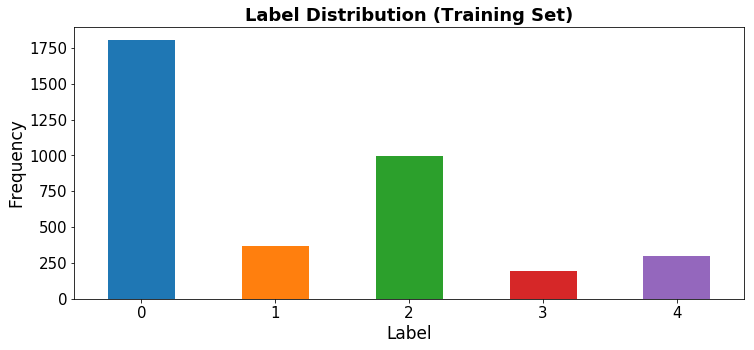

In [8]:
# Label distribution
train_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

We will visualize a random image from every label to get a general sense of the distinctive features that seperate the classes. We will take this into account and try to enhance these features in our preprocessing. For these images there some to be increasingly more spots and stains on the retina as diabetic retinopathy worsens.

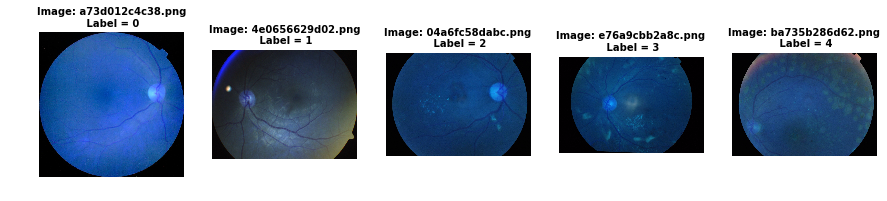

In [9]:
# Example from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = cv2.imread(f"{TRAIN_IMG_PATH}{image_name}")
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## Preprocessing <a id="5"></a>

Here we will use the auto-cropping method with Ben's preprocessing as explained in [this kernel](https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping).

In [10]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    
    :param img: A NumPy Array that will be cropped
    :param tol: The tolerance used for masking
    
    :return: A NumPy array containing the cropped image
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    
    :param img: A NumPy Array that will be cropped
    :param sigmaX: Value used for add GaussianBlur to the image
    
    :return: A NumPy array containing the preprocessed image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

After preprocessing we have managed to enhance the distinctive features in the images. This will increase performance when we train our EfficientNet model.

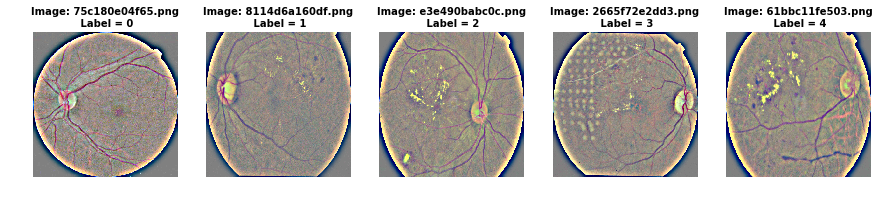

In [11]:
# Example of preprocessed images from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = preprocess_image(cv2.imread(f"{TRAIN_IMG_PATH}{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [12]:
# Labels for training data
y_labels = train_df['diagnosis'].values

## Modeling (EfficientNetB5) <a id="6"></a>

Since we want to optimize the Quadratic Weighted Kappa score we can formulate this challenge as a regression problem. In this way we are more flexible in our optimization and we can yield higher scores than solely optimizing for accuracy. We will optimize a pre-trained EfficientNetB5 with a few added layers. The metric that we try to optimize is the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error). This is the mean of squared differences between our predictions and labels, as showed in the formula below. By optimizing this metric we are also optimizing for Quadratic Weighted Kappa if we round the predictions afterwards.

![](https://study.com/cimages/multimages/16/4e7cf150-0179-4d89-86f2-5cbb1f51c266_meansquarederrorformula.png)

Since we are not provided with that much data (3662 images), we will augment the data to make the model more robust. We will rotate the data on any angle. Also, we will flip the data both horizontally and vertically. Lastly, we will divide the data by 128 for normalization.

In [13]:
# We use a small batch size so we can handle large images easily
BATCH_SIZE = 4

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.15,
                                   preprocessing_function=preprocess_image, 
                                   rescale=1 / 128.)

# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other', 
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(train_df, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis',
                                                  directory = TRAIN_IMG_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other',
                                                  subset='validation')

Found 3113 validated image filenames.
Found 549 validated image filenames.


Thanks to the amazing wrapper by [qubvel](https://github.com/qubvel/efficientnet) we can load in a model like the Keras API. We specify the input shape and that we want the model without the top (the final Dense layer). Then we load in the weights which are provided in [this Kaggle dataset](https://www.kaggle.com/ratthachat/efficientnet-keras-weights-b0b5). Note that we will use the [RAdam optimizer](https://arxiv.org/pdf/1908.03265v1.pdf) since it often yields better convergence than Vanilla Adam. Thanks to CyberZHG who implemented [RAdam for Keras](https://github.com/CyberZHG/keras-radam/blob/master/keras_radam/optimizers.py).

In [14]:
# Code Source: https://github.com/CyberZHG/keras-radam/blob/master/keras_radam/optimizers.py
class RAdam(keras.optimizers.Optimizer):
    """RAdam optimizer.
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        weight_decay: float >= 0. Weight decay for each param.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
        total_steps: int >= 0. Total number of training steps. Enable warmup by setting a positive value.
        warmup_proportion: 0 < warmup_proportion < 1. The proportion of increasing steps.
        min_lr: float >= 0. Minimum learning rate after warmup.
    # References
        - [Adam - A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        - [On The Variance Of The Adaptive Learning Rate And Beyond](https://arxiv.org/pdf/1908.03265v1.pdf)
    """

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            decay_steps = self.total_steps - warmup_steps
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                lr * (1.0 - K.minimum(t, decay_steps) / decay_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t) + self.epsilon)

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t > 5, r_t * m_corr_t / v_corr_t, m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {
            'lr': float(K.get_value(self.lr)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [15]:
class GroupNormalization(Layer):
    """Group normalization layer
    Group Normalization divides the channels into groups and computes within each group
    the mean and variance for normalization. GN's computation is independent of batch sizes,
    and its accuracy is stable in a wide range of batch sizes
    # Arguments
        groups: Integer, the number of groups for Group Normalization.
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `BatchNormalization`.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a model.
    # Output shape
        Same shape as input.
    # References
        - [Group Normalization](https://arxiv.org/abs/1803.08494)
    """

    def __init__(self,
                 groups=32,
                 axis=-1,
                 epsilon=1e-5,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(GroupNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        dim = input_shape[self.axis]

        if dim is None:
            raise ValueError('Axis ' + str(self.axis) + ' of '
                             'input tensor should have a defined dimension '
                             'but the layer received an input with shape ' +
                             str(input_shape) + '.')

        if dim < self.groups:
            raise ValueError('Number of groups (' + str(self.groups) + ') cannot be '
                             'more than the number of channels (' +
                             str(dim) + ').')

        if dim % self.groups != 0:
            raise ValueError('Number of groups (' + str(self.groups) + ') must be a '
                             'multiple of the number of channels (' +
                             str(dim) + ').')

        self.input_spec = InputSpec(ndim=len(input_shape),
                                    axes={self.axis: dim})
        shape = (dim,)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, **kwargs):
        input_shape = K.int_shape(inputs)
        tensor_input_shape = K.shape(inputs)

        # Prepare broadcasting shape.
        reduction_axes = list(range(len(input_shape)))
        del reduction_axes[self.axis]
        broadcast_shape = [1] * len(input_shape)
        broadcast_shape[self.axis] = input_shape[self.axis] // self.groups
        broadcast_shape.insert(1, self.groups)

        reshape_group_shape = K.shape(inputs)
        group_axes = [reshape_group_shape[i] for i in range(len(input_shape))]
        group_axes[self.axis] = input_shape[self.axis] // self.groups
        group_axes.insert(1, self.groups)

        # reshape inputs to new group shape
        group_shape = [group_axes[0], self.groups] + group_axes[2:]
        group_shape = K.stack(group_shape)
        inputs = K.reshape(inputs, group_shape)

        group_reduction_axes = list(range(len(group_axes)))
        group_reduction_axes = group_reduction_axes[2:]

        mean = K.mean(inputs, axis=group_reduction_axes, keepdims=True)
        variance = K.var(inputs, axis=group_reduction_axes, keepdims=True)

        inputs = (inputs - mean) / (K.sqrt(variance + self.epsilon))

        # prepare broadcast shape
        inputs = K.reshape(inputs, group_shape)
        outputs = inputs

        # In this case we must explicitly broadcast all parameters.
        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            outputs = outputs * broadcast_gamma

        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            outputs = outputs + broadcast_beta

        outputs = K.reshape(outputs, tensor_input_shape)

        return outputs

    def get_config(self):
        config = {
            'groups': self.groups,
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(GroupNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [16]:
# Load in EfficientNetB5
effnet = EfficientNetB5(weights=None,
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))
effnet.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

Batch Normalization becomes unstable with small batch sizes (<16) and that is why we use [Group Normalization ](https://arxiv.org/pdf/1803.08494.pdf) layers instead. Big thanks to [Somshubra Majumdar](https://github.com/titu1994) for building an implementation of Group Normalization for Keras.

Keras makes it incredibly easy to replace layers. Just loop through the layers and replace each Batch Normalization layer with a Group Normalization layer.

In [17]:
# Replace all Batch Normalization layers by Group Normalization layers
for i, layer in enumerate(effnet.layers):
    if "batch_normalization" in layer.name:
        effnet.layers[i] = GroupNormalization(groups=32, axis=-1, epsilon=0.00001)

In [18]:
def build_model():
    """
    A custom implementation of EfficientNetB5
    for the APTOS 2019 competition
    (Regression)
    """
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse',
                  optimizer=RAdam(lr=0.00005), 
                  metrics=['mse', 'acc'])
    print(model.summary())
    return model

# Initialize model
model = build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b5 (Model)      (None, 15, 15, 2048)      28168048  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 28,178,299
Trainable params: 28,178,299
Non-trainable params: 0
_________________________________________________________________
None


We train all layers in the network. This is the traditional transfer learning approach were we can optimize and model for almost any image content. Since the pre-trained model was trained on [ImageNet](http://www.image-net.org/) and not on medical images, there are some limitations to this approach for out challenge.

After each epoch we save the model if it is better than the previous one, according to the Quadratic Weighted Kappa score on the validation set. We also stop training if the MSE on the validation set doesn't go down for 4 epochs. This way we can counter overfitting.

Another option we could use is to directly use Quadratic Weighted Kappa as a loss function. Feel free to experiment with this. An implementation of a [QWK loss function for Tensorflow/Keras can be found in this Kaggle kernel](https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow).

In [19]:
# For tracking Quadratic Weighted Kappa score
kappa_metrics = Metrics()
# Monitor MSE to avoid overfitting and save best model
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=12)
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto', 
                        epsilon=0.0001)

# Begin training
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=35,
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics, es, rlr])

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/35
778/778 [==============================] - 797s 1s/step - loss: 1.5850 - mean_squared_error: 1.5850 - acc: 0.4965 - val_loss: 0.9064 - val_mean_squared_error: 0.9064 - val_acc: 0.6350
val_kappa: 0.6441
Validation Kappa has improved. Saving model.
Epoch 2/35
778/778 [==============================] - 716s 920ms/step - loss: 0.7447 - mean_squared_error: 0.7447 - acc: 0.5469 - val_loss: 0.5206 - val_mean_squared_error: 0.5206 - val_acc: 0.7358
val_kappa: 0.8294
Validation Kappa has improved. Saving model.
Epoch 3/35
778/778 [==============================] - 712s 915ms/step - loss: 0.6163 - mean_squared_error: 0.6163 - acc: 0.5935 - val_loss: 0.4818 - val_mean_squared_error: 0.4818 - val_acc: 0.7464
val_kappa: 0.8136
Epoch 4/35
778/778 [==============================] - 717s 922ms/step - loss: 0.5126 - mean_squared_error: 0.5126 - acc: 0.6430 - val_loss: 0.4216 - val_mean_squared_error: 0.4216 - val_acc: 0.7651
val_kappa: 0.8551
Validation Kappa has improved. Saving model.
Epoc

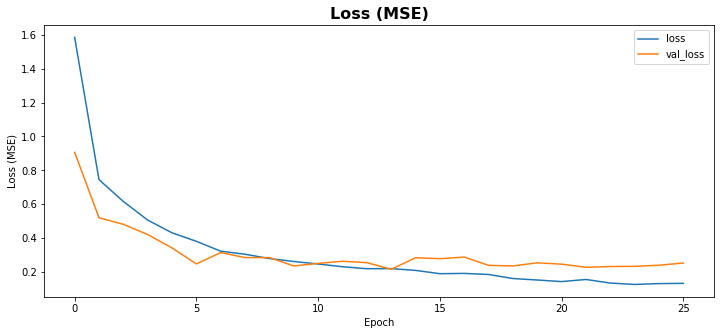

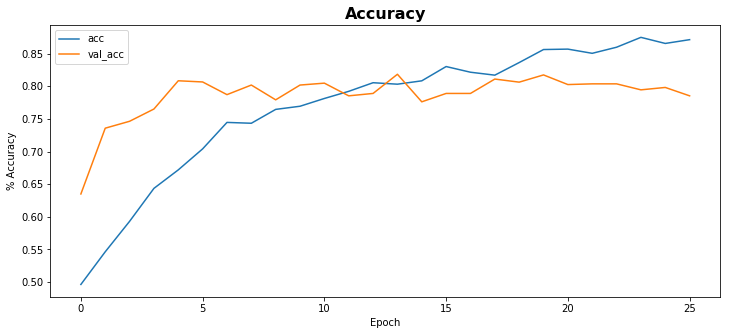

In [20]:
# Visualize mse
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

## Evaluation <a id="7"></a>

In [21]:
# Load best weights according to MSE
model.load_weights(SAVED_MODEL_NAME)

To evaluate our performance we predict values from the generator and round them of to the nearest integer to get valid predictions. After that we calculate the Quadratic Weighted Kappa score on the training set and the validation set.

In [22]:
# Calculate QWK on train set
y_train_preds, train_labels = get_preds_and_labels(model, train_generator)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)

# Calculate score
train_score = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

# Calculate QWK on validation set
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)

# Calculate score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

In [23]:
print(f"The Training Cohen Kappa Score is: {round(train_score, 5)}")
print(f"The Validation Cohen Kappa Score is: {round(val_score, 5)}")

The Training Cohen Kappa Score is: 0.95192
The Validation Cohen Kappa Score is: 0.91902


We can optimize the validation score by doing a [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) over rounding thresholds instead of doing "normal" rounding. The "OptimizedRounder" class by [Abhishek Thakur](https://www.kaggle.com/abhishek) is a great way to do this. The original class can be found in [this Kaggle kernel](https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa).

In [24]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa score
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [25]:
# Optimize on validation data and evaluate again
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
optR = OptimizedRounder()
optR.fit(y_val_preds, val_labels)
coefficients = optR.coefficients()
opt_val_predictions = optR.predict(y_val_preds, coefficients)
new_val_score = cohen_kappa_score(val_labels, opt_val_predictions, weights="quadratic")

In [26]:
print(f"Optimized Thresholds:\n{coefficients}\n")
print(f"The Validation Quadratic Weighted Kappa (QWK)\n\
with optimized rounding thresholds is: {round(new_val_score, 5)}\n")
print(f"This is an improvement of {round(new_val_score - val_score, 5)}\n\
over the unoptimized rounding")

Optimized Thresholds:
[0.54672852 1.54995117 2.56860352 2.94492187]

The Validation Quadratic Weighted Kappa (QWK)
with optimized rounding thresholds is: 0.9345

This is an improvement of 0.01548
over the unoptimized rounding


## Submission <a id="8"></a>

Since the test set is not that large we will not be using a generator for making the final predictions on the test set.

In [27]:
# Place holder for diagnosis column
test_df['diagnosis'] = np.zeros(test_df.shape[0]) 
# For preprocessing test images
test_generator = ImageDataGenerator(preprocessing_function=preprocess_image, 
                                    rescale=1 / 128.).flow_from_dataframe(test_df, 
                                                                          x_col='id_code', 
                                                                          y_col='diagnosis',
                                                                          directory=TEST_IMG_PATH,
                                                                          target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                                          batch_size=BATCH_SIZE,
                                                                          class_mode='other',
                                                                          shuffle=False)

Found 1928 validated image filenames.


As mentioned earlier, we use custom thresholds to optimize our score. The same thresholds should be used when creating the final predictions.

In [28]:
# Make final predictions, round predictions and save to csv
y_test, _ = get_preds_and_labels(model, test_generator)
y_test = optR.predict(y_test, coefficients).astype(np.uint8)
test_df['diagnosis'] = y_test
# Remove .png from ids
test_df['id_code'] = test_df['id_code'].str.replace(r'.png$', '')
test_df.to_csv('submission.csv', index=False)

After creating the submission I always check the format and the distribution of the test predictions. Do they makes sense given the label distribution of the training data?

In [29]:
# Check submission
print("Submission File")
display(test_df.head())

Submission File


,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,2
3,00836aaacf06,2
4,009245722fa4,2


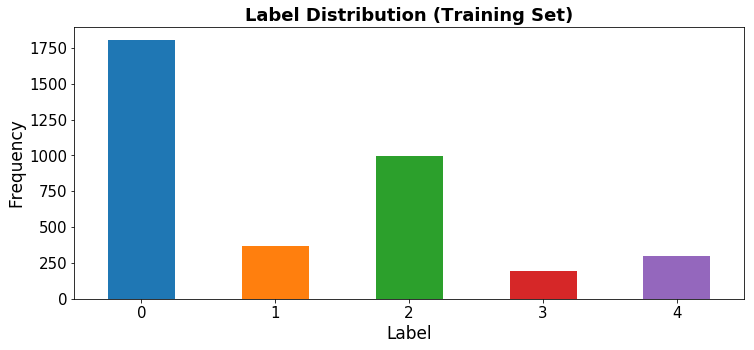

In [30]:
# Label distribution
train_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

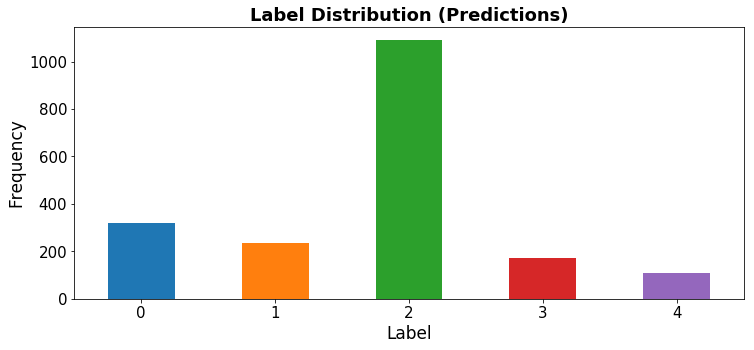

In [31]:
# Distribution of predictions
test_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                      figsize=(12,5), 
                                                      rot=0)
plt.title("Label Distribution (Predictions)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

In [32]:
# Check kernels run-time. GPU limit for this competition is set to ± 9 hours.
t_finish = time.time()
total_time = round((t_finish-t_start) / 3600, 4)
print('Kernel runtime = {} hours ({} minutes)'.format(total_time, 
                                                      int(total_time*60)))

Kernel runtime = 6.3849 hours (383 minutes)


That's it! Feel free to experiment with this kernel and try a larger implementation of EfficientNet. This kernel provides weights for EfficientNetB0 through B5. Weights for EfficientNetB6 and B7 can be found in [Google AI's repository for EfficientNet](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet).

**If you like this Kaggle kernel, feel free to give an upvote and leave a comment! I will try to implement your suggestions in this kernel!**